In [1]:
cd ../..

/home/cridonoso/Documents/ASTROMER


In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import sys,os
from core.data import load_dataset, pretraining_pipeline

%load_ext autoreload
%autoreload 2

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# ASTROMER input format

In [5]:
dataset_name = 'testing'
dataset_path = './data/records/{}/fold_0/{}/train/'.format(dataset_name, dataset_name)
dataset = load_dataset(dataset_path, repeat=1, shuffle=True)
dataset = pretraining_pipeline(dataset, batch_size=256, max_obs=200, msk_frac=0.5, rnd_frac=0.2, same_frac=0.2)
objects = pd.read_csv('./data/records/{}/fold_0/{}/objects.csv'.format(dataset_name, dataset_name))
objects

[INFO] Shuffling
[INFO] Pretraining mode. Random 200-len windows


,label,size
0,Cep_0,939
1,LPV,2443


tf.Tensor([0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0.], shape=(20,), dtype=float32)


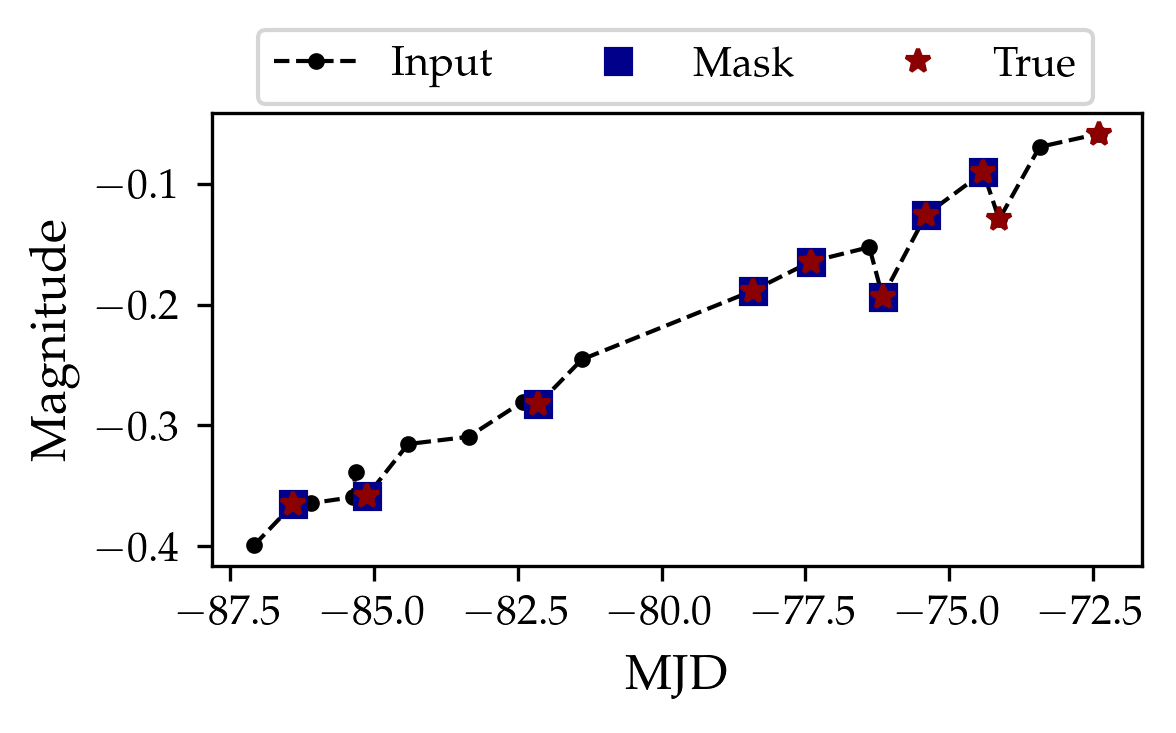

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(4,2), sharex=True, sharey=True, 
                         gridspec_kw={'hspace': 0.3, 'wspace': 0.2}, dpi=300)
lim = 20
start = 0

for i, (batch, (target, mask)) in enumerate(dataset):
    x_input  = batch['input'][-1][start:start+lim]
    t_sample = batch['times'][-1][start:start+lim]
    x_output = target[-1][start:start+lim]
    
    
    mask_in  = tf.squeeze(batch['mask_in'][-1][start:start+lim])
    print(mask_in)
    mask_out = tf.squeeze(mask[-1][start:start+lim])


    times_masked = tf.boolean_mask(t_sample, mask_in)
    serie_masked = tf.boolean_mask(x_input, mask_in)


    times_masked_out = tf.boolean_mask(t_sample, mask_out)
    serie_masked_out = tf.boolean_mask(x_input, mask_out)

    axes.plot(t_sample, x_output, color='k', linestyle='--', marker='.', label='Input', linewidth=1)
    axes.plot(times_masked, serie_masked, marker='s', linestyle='', color='darkblue', label='Mask', linewidth=1)
    axes.plot(times_masked_out, serie_masked_out, color='darkred', linestyle='', marker='*', label='True', linewidth=1)

    axes.set_xlabel('MJD', fontsize=12)
    axes.set_ylabel('Magnitude', fontsize=12)    
    axes.legend(ncol=3, bbox_to_anchor=(0.97, 1.23))
    break

In [14]:
# fig.savefig('./presentation/figures/input.pdf', format='pdf', bbox_inches='tight')

# Classification input 

In [12]:
import tensorflow as tf 
import os, sys
import matplotlib.pyplot as plt
from core.data import balanced_records

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
df_labels = pd.read_csv('./data/records/naul_macho/fold_0/naul_macho/objects.csv')
class_names = df_labels['label'].values
n_classes = len(class_names)
df_labels

,label,size
0,Ceph 1st,556
1,Ceph Fund,964
2,EB,5389
3,LPV WoodA,255
4,LPV WoodB,658
5,LPV WoodC,888
6,LPV WoodD,630
7,RRL + GB,185
8,RRL AB,5976
9,RRL C,1420


In [48]:
dataset = balanced_records('./data/records/ogle/fold_0/ogle/train/', 256, n_classes=n_classes, max_obs=200)

In [49]:
for batch, y in dataset:
    print(batch.keys())
    break

dict_keys(['input', 'times', 'mask_in'])


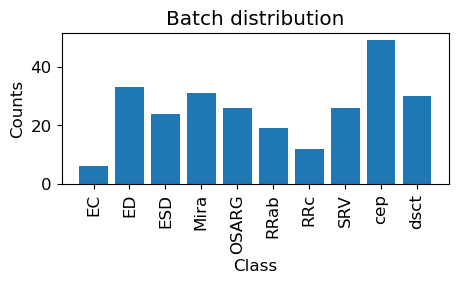

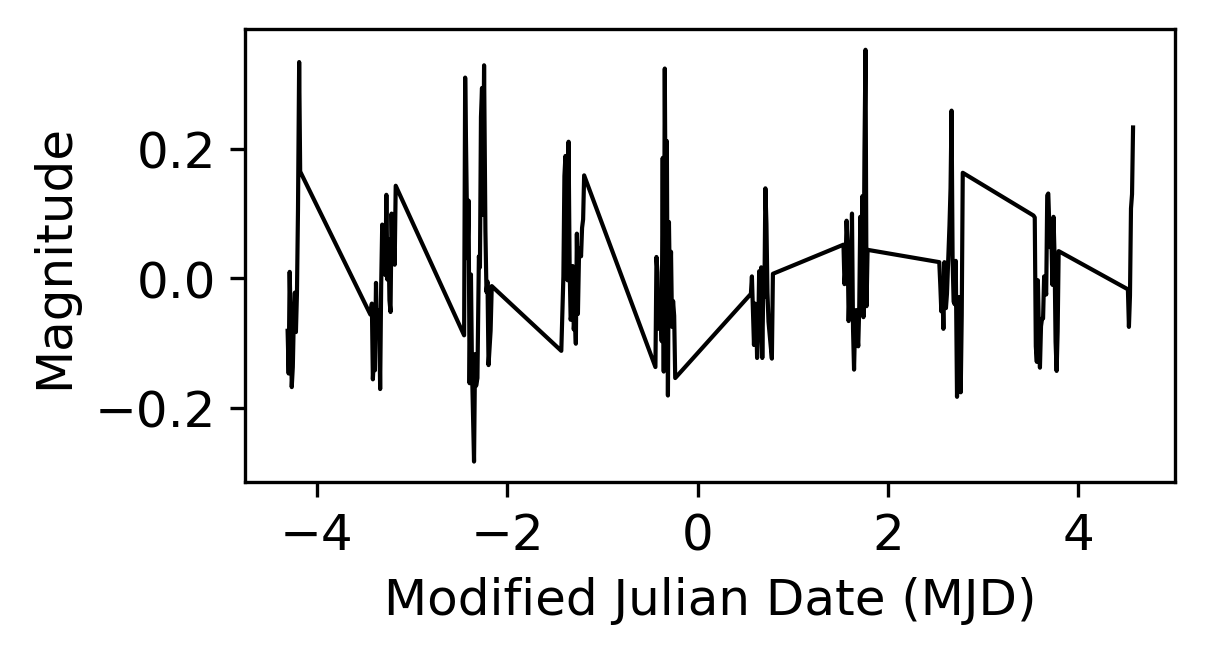

In [57]:
plt.rcParams.update({'font.size': 12})
for batch, y in dataset:
    y_label  = y[-1]
    x_input  = batch['input'][-1]
    t_sample = batch['times'][-1]
    
    mask_in  = tf.squeeze(batch['mask_in'][-1])

    times_masked = tf.boolean_mask(t_sample, mask_in)
    serie_masked = tf.boolean_mask(x_input, mask_in)
    
    # BATCH DISTRIBUTION
    plt.figure(figsize=(5,2), dpi=100)
    batch_labels = np.argmax(y.numpy(), 1)
    uniques, counts = np.unique(batch_labels, return_counts=True)
    x = range(len(uniques))
    plt.bar(x, counts)
    plt.xticks(x, class_names[:len(uniques)], rotation=90)
    plt.title('Batch distribution')
    plt.xlabel('Class')
    plt.ylabel('Counts')
    plt.show()
    
    # Lightcurve
    fig, axes = plt.subplots(1, 1, figsize=(4,2), sharex=True, sharey=True, 
                             gridspec_kw={'hspace': 0.3, 'wspace': 0.2}, dpi=300)
    axes.plot(t_sample, x_input, color='k', linestyle='-', marker='', label='Input', linewidth=1)
#     axes.set_title('{}'.format(str(class_names[y_label])))
    axes.set_xlabel('Modified Julian Date (MJD)')
    axes.set_ylabel('Magnitude')   
#     fig.savefig('presentation/figures/raw_input.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    break